## 1. Build Regression Model with TF DenseFeatures

### Overview
- Used preprocessed dataset from TF regression tutorial https://www.tensorflow.org/tutorials/keras/regression
- Used TF feature column API and TF DenseFeatures instead of the methods used in tutorial

### Dataset Preprocessing From Tutorial

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [8]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [25]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [26]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [27]:
dataset = dataset.dropna()

In [28]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [29]:
#split 80 20 train test split
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [30]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [31]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


In [32]:
train_labels = train_dataset['MPG']

In [33]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [34]:
categorical_feature_list = ['Origin']
# for the sake of this exercise treat Model Year and Cylinders as numerical but could process differently
numerical_feature_list = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear']

In [35]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset[numerical_feature_list])
normed_test_data = norm(test_dataset[numerical_feature_list])

In [36]:
norm_train_data = pd.concat([ train_dataset[categorical_feature_list + ['MPG']],  normed_train_data], 
                            axis=1, sort=False)
norm_test_data = pd.concat([ test_dataset[categorical_feature_list + ['MPG']], normed_test_data], axis=1, sort=False)

In [37]:
norm_train_data.to_csv("mpg_train_data.csv", index=False)
norm_test_data.to_csv("mpg_test_data.csv", index=False)

In [38]:
norm_train_data.head()

,Origin,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear
146,USA,28.0,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,USA,22.3,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,USA,12.0,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,USA,38.0,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,Japan,33.8,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


### Load Preprocessed Dataset

- Use TF Dataset API and Feature Column APIs instead

In [39]:
train_data = pd.read_csv("mpg_train_data.csv" )
test_data = pd.read_csv("mpg_test_data.csv" )

In [40]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32, shuffle=True):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [41]:
PREDICTOR_FIELD = 'MPG'
batch_size = 128
train_ds = df_to_dataset(train_data, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_data, PREDICTOR_FIELD, batch_size=batch_size, shuffle=False)

In [42]:
sample_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Convert Origin Categorical Feature to One Hot Encoded Feature

In [43]:
# only feature 
v_list = tf.feature_column.categorical_column_with_vocabulary_list("Origin", 
                                                            train_data['Origin'].unique())
one_hot_origin_feature = tf.feature_column.indicator_column(v_list)

In [44]:
print("Example categorical field:\n{}".format(one_hot_origin_feature))
demo(one_hot_origin_feature, sample_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0

### Create Numerical Features

NOTE: We do not use the normalizer function here because the dataset has already been normalized.

In [45]:
#convert numerical features, these features have already been normalized
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(
                    key=c,  dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [46]:
tf_numerical_feature_list = create_tf_numerical_feature_cols(numerical_feature_list)

In [47]:
tf_numerical_feature_list

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [48]:
# take first numerical feature
test_cont_var1 = tf_numerical_feature_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, sample_batch)

Example continuous field:
NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.8693

### Combine TF Features with DenseFeatures

In [49]:
feature_columns = [ one_hot_origin_feature ] + tf_numerical_feature_list

In [50]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [51]:
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [52]:
# Use same architecture as example
def build_model(dense_feature_layer):
    model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    return model

In [53]:
model = build_model(dense_feature_layer)

In [54]:
# validation split

In [55]:
# No validation set b/c need to build separate TF dataset
EPOCHS = 2000
# Set to patience to 100 so it trains to end of epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/2000
3/3 [==============================] - 1s 474ms/step - loss: 617.6135 - mae: 23.4377 - mse: 611.8636
Epoch 2/2000
3/3 [==============================] - 0s 12ms/step - loss: 593.6445 - mae: 22.9032 - mse: 586.4420
Epoch 3/2000
3/3 [==============================] - 0s 10ms/step - loss: 572.5823 - mae: 22.4877 - mse: 567.0864
Epoch 4/2000
3/3 [==============================] - 0s 9ms/step - loss: 543.3481 - mae: 22.0846 - mse: 548.2549
Epoch 5/2000
3/3 [==============================] - 0s 9

3/3 [==============================] - 0s 12ms/step - loss: 6.5836 - mae: 1.8249 - mse: 6.4510
Epoch 142/2000
3/3 [==============================] - 0s 16ms/step - loss: 6.3862 - mae: 1.8272 - mse: 6.4761
Epoch 143/2000
3/3 [==============================] - 0s 26ms/step - loss: 6.6972 - mae: 1.8144 - mse: 6.4749
Epoch 144/2000
3/3 [==============================] - 0s 17ms/step - loss: 6.3021 - mae: 1.8553 - mse: 6.6410
Epoch 145/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.3574 - mae: 1.8459 - mse: 6.5679
Epoch 146/2000
3/3 [==============================] - 0s 21ms/step - loss: 6.7337 - mae: 1.8744 - mse: 6.7583
Epoch 147/2000
3/3 [==============================] - 0s 15ms/step - loss: 6.5752 - mae: 1.8257 - mse: 6.4856
Epoch 148/2000
3/3 [==============================] - 0s 23ms/step - loss: 6.5270 - mae: 1.8066 - mse: 6.4712
Epoch 149/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.3346 - mae: 1.8202 - mse: 6.5578
Epoch 150/2000
3/3 [=====

In [56]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 6.0469 - mae: 1.9154 - mse: 6.0469


In [57]:
test_labels = test_data[PREDICTOR_FIELD].values

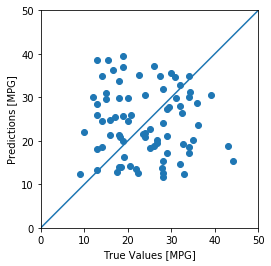

In [58]:
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


### Show Model Prediction Output

In [59]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [60]:
model_output_df.head()

,pred,actual_value
0,30.906088,15.0
1,22.120295,10.0
2,12.418271,9.0
3,18.323500,25.0
4,19.856155,19.0


## 2. Model Evaluation 

### Preparing Regression Output for Binary Scoring Model Evaluation

- Create binary label for mileage prediction over 25 miles per gallon
    - 0 = Not Fuel Efficient, < 25 MPG
    - 1 = Fuel Efficient >= 25 MPG

In [61]:
# Convert Regression Output to binary classification output
model_output_df.head()

,pred,actual_value
0,30.906088,15.0
1,22.120295,10.0
2,12.418271,9.0
3,18.323500,25.0
4,19.856155,19.0


In [62]:
def convert_to_binary(df, pred_field, actual_field):
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=25 else 0 )
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=25 else 0)
    return df

In [63]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,30.906088,15.0,1,0
1,22.120295,10.0,0,0
2,12.418271,9.0,0,0
3,18.323500,25.0,0,1
4,19.856155,19.0,0,0


### Classification Common Model Evaluation Metrics

In [64]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [65]:
print(classification_report(binary_df['label_value'], binary_df['score']))

              precision    recall  f1-score   support

           0       0.51      0.54      0.52        41
           1       0.46      0.43      0.44        37

    accuracy                           0.49        78
   macro avg       0.48      0.48      0.48        78
weighted avg       0.49      0.49      0.49        78



In [66]:
#F1
f1_score(binary_df['label_value'], binary_df['score'], average='weighted')

0.4861619861619862

In [67]:
#AUC - area under the ROC curve
roc_auc_score(binary_df['label_value'], binary_df['score'])

0.4845088991430455

### Brier Score

In [68]:
random_predictions = np.random.random((100))
random_predictions

array([0.67432785, 0.58212844, 0.01385163, 0.46731135, 0.46874771,
       0.61163964, 0.92317466, 0.351266  , 0.44169268, 0.13679187,
       0.26336094, 0.67926446, 0.22377975, 0.85122349, 0.45737705,
       0.30533685, 0.80695758, 0.03389336, 0.16773184, 0.14130643,
       0.97885167, 0.90365236, 0.6782964 , 0.31812958, 0.40985342,
       0.50450315, 0.05357109, 0.44024374, 0.7896074 , 0.41209843,
       0.38841535, 0.90129655, 0.62111407, 0.51527218, 0.85117122,
       0.6782726 , 0.27040516, 0.00557659, 0.33210783, 0.26314339,
       0.08029584, 0.31830818, 0.42544698, 0.10999099, 0.67461994,
       0.54305176, 0.4568714 , 0.03314542, 0.13252138, 0.60032628,
       0.38362441, 0.32316668, 0.46037267, 0.98530593, 0.54567008,
       0.19192243, 0.75012179, 0.15963533, 0.75283649, 0.14857704,
       0.89079988, 0.52641362, 0.60868095, 0.53085357, 0.22338842,
       0.37165034, 0.17957936, 0.26106075, 0.73726973, 0.00833603,
       0.15328682, 0.12134011, 0.40321935, 0.81269058, 0.04943

In [69]:
random_labels = np.random.choice([0, 1], 100)
random_labels

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

- Convert probability to binary predictions

In [70]:
probability_prediction_df = pd.DataFrame({"prob_prediction": random_predictions,
                "binary_prediction": np.array([ 1 if abs(x)>=0.5 else 0 for x in random_predictions], dtype=int),
                                "label": random_labels})

In [71]:
probability_prediction_df.head()

,prob_prediction,binary_prediction,label
0,0.674328,1,0
1,0.582128,1,1
2,0.013852,0,1
3,0.467311,0,0
4,0.468748,0,1


In [72]:
y_true = probability_prediction_df['label'].values 
y_pred = probability_prediction_df['binary_prediction'].values

In [73]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.54


In [74]:
bs_loss = brier_score_loss(y_true, probability_prediction_df['prob_prediction'])
print(bs_loss)

0.31525501974156467


### Misclassified

In [75]:
missclassified_df = probability_prediction_df[probability_prediction_df['binary_prediction']!=probability_prediction_df['label']]

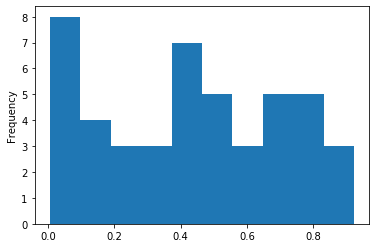

In [76]:
missclassified_df['prob_prediction'].plot(kind='hist')

## 3. Demographic Group Bias Analysis

- Select groups to analyze
- Prepare data 
- Analyze groups


### Select groups to analyze
- Selected 'origin' field which gives the country of origin for the car.

In [77]:
#combine binary df with original test df, order was not shuffled so can do

In [78]:
merged_binary_df = binary_df.assign(origin = test_data['Origin'].values)

In [79]:
merged_binary_df.head()

,pred,actual_value,score,label_value,origin
0,30.906088,15.0,1,0,USA
1,22.120295,10.0,0,0,USA
2,12.418271,9.0,0,0,USA
3,18.323500,25.0,0,1,Japan
4,19.856155,19.0,0,0,USA


### Prepare Data

In [80]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [81]:
ae_df, _ = preprocess_input_df(merged_binary_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [35]}


### Analyze Groups

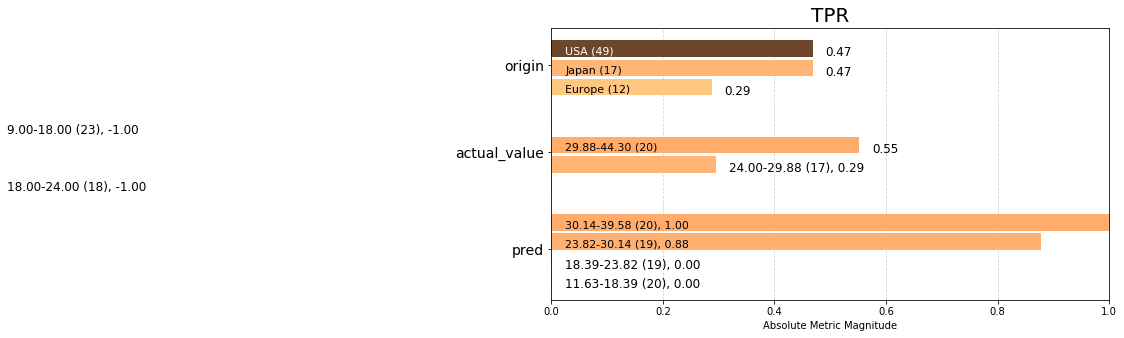

In [82]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

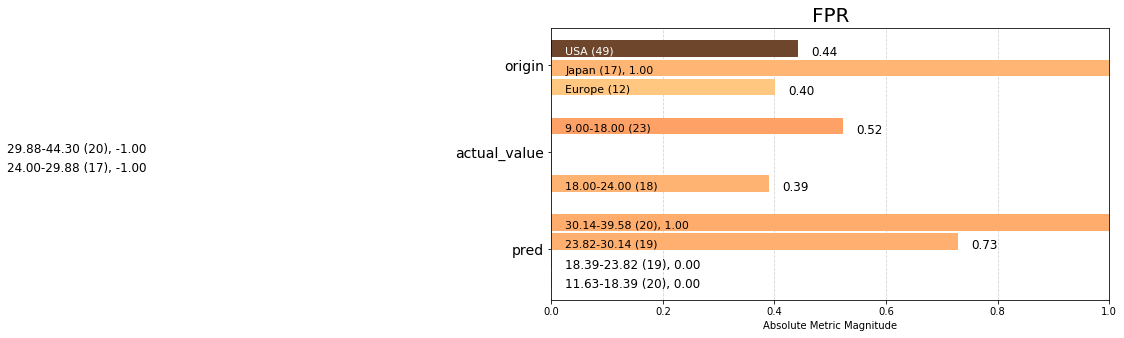

In [83]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

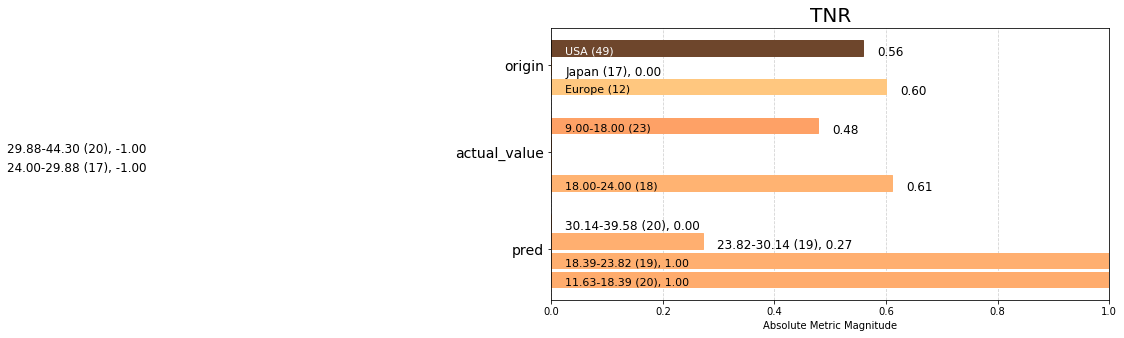

In [84]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

In [85]:
# Bias Report - http://aequitas.dssg.io/audit/eg1cp7ku/adult_rf_binary/

## 4. Train Uncertainty Estimation Model with TF Probability

### Instructions
- Using MPG model from earlier, create uncertainty estimation model with TF Probability.
- In particular, we will focus on building a model that accounts for Aleatoric Uncertainty.

In [86]:
import tensorflow_probability as tfp

### Aleatoric Uncertainty
- Known Unknowns
- 2 Main Changes to our network 
    - Add a second unit to the last dense layer before passing it to Tensorflow Probability layer to model for the predictor y and the heteroscedasticity or unequal scattering of data
    - DistributionLambda distribution mean and std
- DistributionLambda is a special Keras layer that uses a Python lambda to construct a distribution based on the layer inputs and the output of the final layer of the model is passed into the loss function. Lastly. this model will return a distribution for both mean and standard deviation.

In [87]:
train_label_stats = train_labels.describe()
train_label_stats

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [114]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(  
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])

            )
         )
  
        
        
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

### Train Probability Model

In [115]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=500)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1/500
3/3 [==============================] - 1s 220ms/step - loss: 253.1189 - mse: 446.1531
Epoch 2/500
3/3 [==============================] - 0s 11ms/step - loss: 10.3780 - mse: 2631.9246
Epoch 3/500
3/3 [==============================] - 0s 21ms/step - loss: 15.7406 - mse: 16460.8457
Epoch 4/500
3/3 [==============================] - 0s 15ms/step - loss: 11.8353 - mse: 28250.3320
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 8.4765 - mse: 29876.6875
Epoch 6/500
3/3 [==============================] - 0s 15ms/step - loss: 6.5385 - mse: 19727.1328
Epoch 7/500
3/3 [==============================] - 0s 25ms/step - loss: 5.6657 - mse: 14520.6875
Epoch 8/500
3/3 [==============================] - 0s 28ms/step - loss: 5.4413 - mse: 12523.3691
Epoch 9/500
3/3 [==============================] - 0s 20ms/step - loss: 5.5132 - mse: 11232.1973
Epoch 10/500
3/3 [==============================] - 0s 13ms/step - loss: 5.6732 - mse: 19407.8496
Epoch 11/500
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 3.7820 - mse: 1421.2423
Epoch 86/500
3/3 [==============================] - 0s 22ms/step - loss: 3.7845 - mse: 1553.6748
Epoch 87/500
3/3 [==============================] - 0s 12ms/step - loss: 3.7625 - mse: 1334.5226
Epoch 88/500
3/3 [==============================] - 0s 12ms/step - loss: 3.6759 - mse: 1392.3237
Epoch 89/500
3/3 [==============================] - 0s 13ms/step - loss: 3.6492 - mse: 1305.6595
Epoch 90/500
3/3 [==============================] - 0s 13ms/step - loss: 3.5937 - mse: 1370.1710
Epoch 91/500
3/3 [==============================] - 0s 11ms/step - loss: 3.5623 - mse: 1111.2761
Epoch 92/500
3/3 [==============================] - 0s 12ms/step - loss: 3.5324 - mse: 738.4182
Epoch 93/500
3/3 [==============================] - 0s 10ms/step - loss: 3.5203 - mse: 834.1545
Epoch 94/500
3/3 [==============================] - 0s 20ms/step - loss: 3.4571 - mse: 730.2095
Epoch 95/500
3/3 [============================

3/3 [==============================] - 0s 12ms/step - loss: 1.8659 - mse: 7.3130
Epoch 256/500
3/3 [==============================] - 0s 14ms/step - loss: 1.7968 - mse: 8.0324
Epoch 257/500
3/3 [==============================] - 0s 12ms/step - loss: 1.7692 - mse: 6.3935
Epoch 258/500
3/3 [==============================] - 0s 11ms/step - loss: 1.8030 - mse: 7.6750
Epoch 259/500
3/3 [==============================] - 0s 10ms/step - loss: 1.8234 - mse: 8.3452
Epoch 260/500
3/3 [==============================] - 0s 14ms/step - loss: 1.7931 - mse: 6.8303
Epoch 261/500
3/3 [==============================] - 0s 16ms/step - loss: 1.9348 - mse: 8.0939
Epoch 262/500
3/3 [==============================] - 0s 10ms/step - loss: 1.8799 - mse: 7.8786
Epoch 263/500
3/3 [==============================] - 0s 12ms/step - loss: 2.1814 - mse: 8.4885
Epoch 264/500
3/3 [==============================] - 0s 12ms/step - loss: 2.0463 - mse: 12.4797
Epoch 265/500
3/3 [==============================] - 0s 11ms/st

3/3 [==============================] - ETA: 0s - loss: 1.6848 - mse: 4.416 - 0s 13ms/step - loss: 1.7998 - mse: 6.5147
Epoch 342/500
3/3 [==============================] - 0s 12ms/step - loss: 1.7206 - mse: 7.0307
Epoch 343/500
3/3 [==============================] - 0s 14ms/step - loss: 1.7739 - mse: 6.5580
Epoch 344/500
3/3 [==============================] - 0s 13ms/step - loss: 1.8126 - mse: 7.8479
Epoch 345/500
3/3 [==============================] - 0s 12ms/step - loss: 1.9044 - mse: 9.6543
Epoch 346/500
3/3 [==============================] - 0s 13ms/step - loss: 1.9785 - mse: 10.6815
Epoch 347/500
3/3 [==============================] - 0s 15ms/step - loss: 1.9026 - mse: 11.9087
Epoch 348/500
3/3 [==============================] - 0s 13ms/step - loss: 1.9023 - mse: 11.4596
Epoch 349/500
3/3 [==============================] - 0s 11ms/step - loss: 1.8240 - mse: 8.5482
Epoch 350/500
3/3 [==============================] - 0s 14ms/step - loss: 1.8067 - mse: 6.7009
Epoch 351/500
3/3 [====

### Extract Mean and Standard Deviation Output

In [116]:
feature_column_list = categorical_feature_list + numerical_feature_list
x_tst = dict(test_data[feature_column_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [121]:
m[0:10]

<tf.Tensor: id=44282, shape=(10, 1), dtype=float32, numpy=
array([[13.958912 ],
       [10.016899 ],
       [ 9.9466305],
       [25.863235 ],
       [18.2761   ],
       [13.193605 ],
       [13.72304  ],
       [12.27141  ],
       [18.184198 ],
       [32.166622 ]], dtype=float32)>

In [122]:
s[0:10]

<tf.Tensor: id=44286, shape=(10, 1), dtype=float32, numpy=
array([[1.1909614 ],
       [1.0459578 ],
       [0.88034827],
       [2.435342  ],
       [1.7067968 ],
       [1.0082203 ],
       [0.98526174],
       [1.011966  ],
       [1.5310878 ],
       [4.0925946 ]], dtype=float32)>

In [117]:
prob_outputs = {
    "pred": prob_preds.flatten(),
    "actual_value": test_data['MPG'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [118]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,38.096432,15.0,13.958912,1.190961
1,22.612707,10.0,10.016899,1.045958
2,11.930942,9.0,9.946630,0.880348
3,33.007366,25.0,25.863235,2.435342
4,22.221416,19.0,18.276100,1.706797


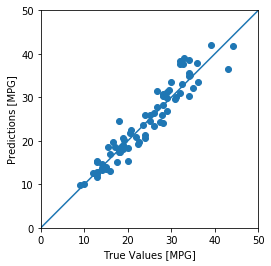

In [119]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 5. Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [82]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [83]:
import shap
shap.initjs()

### Train Model without Dense Features

In [84]:
def build_shap_model( num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [85]:
shap_num_features = len( numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
#shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model( shap_num_features)

In [86]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit( normed_train_data, train_labels,  callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Train on 314 samples
Epoch 1/1000
314/314 [==============================] - 0s 361us/sample - loss: 566.0826 - mae: 22.5732 - mse: 566.0826
Epoch 2/1000
314/314 [==============================] - 0s 49us/sample - loss: 506.0068 - mae: 21.1827 - mse: 506.0068
Epoch 3/1000
314/314 [==============================] - 0s 51us/sample - loss: 447.1930 - mae: 19.7300 - mse: 447.1930
Epoch 4/1000
314/314 [==============================] - 0s 150us/sample - loss: 382.8605 - mae: 18.0572 - mse: 382.8605
Epoch 5/1000
314/314 [==============================] - 0s 183us/sample - loss: 315.4346 - mae: 16.1494 - mse: 315.4346
Epoch 6/1000
314/314 [==============================] - 0s 159us/sample - loss: 247.7844 - mae: 14.1544 - mse: 247.7844
Epoch 7/1000
314/314 [==============================] - 0s 192us/sample - loss: 184.5634 - mae: 12.0866 - mse: 184.5634
Epoch 8/1000
314/314 [==============================] - 0s 156us/sample - loss: 129.7116 - mae: 10.0677 - mse: 129.7116
Epoch 9/1000
314/314 

314/314 [==============================] - 0s 100us/sample - loss: 6.4780 - mae: 1.8255 - mse: 6.4780
Epoch 141/1000
314/314 [==============================] - 0s 89us/sample - loss: 6.4922 - mae: 1.8359 - mse: 6.4922
Epoch 142/1000
314/314 [==============================] - 0s 85us/sample - loss: 6.4234 - mae: 1.7933 - mse: 6.4234
Epoch 143/1000
314/314 [==============================] - 0s 71us/sample - loss: 6.4040 - mae: 1.8186 - mse: 6.4040
Epoch 144/1000
314/314 [==============================] - 0s 90us/sample - loss: 6.5803 - mae: 1.8277 - mse: 6.5803
Epoch 145/1000
314/314 [==============================] - 0s 90us/sample - loss: 6.4442 - mae: 1.8238 - mse: 6.4442
Epoch 146/1000
314/314 [==============================] - 0s 89us/sample - loss: 6.5724 - mae: 1.8323 - mse: 6.5724
Epoch 147/1000
314/314 [==============================] - 0s 86us/sample - loss: 6.3393 - mae: 1.8099 - mse: 6.3393
Epoch 148/1000
314/314 [==============================] - 0s 102us/sample - loss: 6.30

### Use KMeans to Summarize Dataset

In [87]:
df_train_normed_summary = shap.kmeans(normed_train_data.values, 25)


In [88]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(shap_model.predict, df_train_normed_summary)

In [89]:
# may need to install ipywidgets to see status visualization
'''
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
'''

'\npip install ipywidgets\njupyter nbextension enable --py widgetsnbextension\n'

In [90]:
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(normed_train_data.values)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


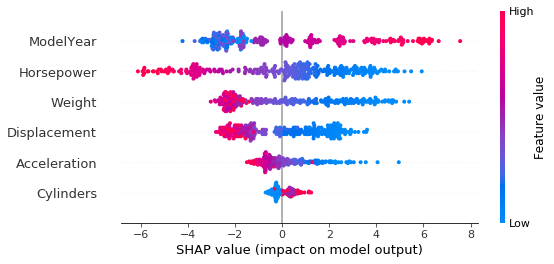

In [91]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], normed_train_data)

In [92]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], normed_train_data.iloc[INSTANCE_NUM,:])

In [93]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], normed_train_data.iloc[0:NUM_ROWS])